<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#16-14.-프로젝트-:-SRGAN-활용하기" data-toc-modified-id="16-14.-프로젝트-:-SRGAN-활용하기-1">16-14. 프로젝트 : SRGAN 활용하기</a></span><ul class="toc-item"><li><span><a href="#프로젝트-1-:-직접-고른-이미지로-SRGAN-실험하기" data-toc-modified-id="프로젝트-1-:-직접-고른-이미지로-SRGAN-실험하기-1.1">프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기</a></span><ul class="toc-item"><li><span><a href="#프로젝트-1-1." data-toc-modified-id="프로젝트-1-1.-1.1.1">프로젝트 1-1.</a></span></li><li><span><a href="#프로젝트-1-2." data-toc-modified-id="프로젝트-1-2.-1.1.2">프로젝트 1-2.</a></span></li></ul></li><li><span><a href="#프로젝트-2-:-SRGAN을-이용해-고해상도-gif-생성하기" data-toc-modified-id="프로젝트-2-:-SRGAN을-이용해-고해상도-gif-생성하기-1.2">프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기</a></span><ul class="toc-item"><li><span><a href="#1.-gif-파일-불러오기" data-toc-modified-id="1.-gif-파일-불러오기-1.2.1">1. gif 파일 불러오기</a></span></li><li><span><a href="#2.-프레임별-Super-Resolution-진행하기" data-toc-modified-id="2.-프레임별-Super-Resolution-진행하기-1.2.2">2. 프레임별 Super Resolution 진행하기</a></span></li><li><span><a href="#3.-프레임을-합쳐-gif-만들기" data-toc-modified-id="3.-프레임을-합쳐-gif-만들기-1.2.3">3. 프레임을 합쳐 gif 만들기</a></span></li><li><span><a href="#4.-Jupyter-notebook에-gif-표시하기" data-toc-modified-id="4.-Jupyter-notebook에-gif-표시하기-1.2.4">4. Jupyter notebook에 gif 표시하기</a></span></li></ul></li><li><span><a href="#루브릭" data-toc-modified-id="루브릭-1.3">루브릭</a></span></li><li><span><a href="#Postscript" data-toc-modified-id="Postscript-1.4">Postscript</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-1.5">Reference</a></span></li></ul></li></ul></div>

# 16-14. 프로젝트 : SRGAN 활용하기

앞에서 사용했던 SRGAN 구조를 이용해 프로젝트를 수행해 봅시다.

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기
---
이제 여러분이 직접 다른 이미지를 사용해 볼 차례입니다.

앞서 사용했던 `DIV2K` 데이터셋은 bicubic interpolation을 이용해 가로 및 세로 픽셀 수를 1/4로 줄인 저해상도 이미지와 원래 고해상도 이미지 사이에서 학습되었습니다. 이 데이터셋으로 학습된 SRGAN를 이용해 좋은 결과를 얻기 위해서는 위와 같은 과정이 동일하게 진행되는 것이 좋습니다.

아래와 같이 두 가지 다른 단계를 거쳐서 직접 고른 이미지에 대해 SRGAN을 적용해 봅시다. (모델 학습을 진행하는 건 아닙니다❗) 테스트할 이미지를 고를 때, `DIV2K` 의 학습 데이터셋과 비슷한 종류의 이미지가 좋습니다. 일반적으로 자연, 동물, 건물 등의 이미지가 학습에 사용되었으며, 이와 달리 애니메이션 등의 이미지는 고해상도로 잘 변환되지 않을 수 있습니다.

특정 데이터셋에서만 학습되었기 때문에, 일반적으로 좋지 않은 결과가 나올 가능성이 높습니다. 결과와 상관없이 아래 과정만 잘 수행해봅시다.

### 프로젝트 1-1.

1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

(853, 1280, 3)


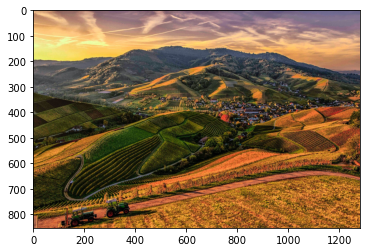

In [1]:
import cv2
import matplotlib.pylab as plt

img_hr = cv2.imread('images/pexels-christian-heitz-842711.jpg', cv2.IMREAD_COLOR)

# RGB로 변환
b, g, r = cv2.split(img_hr)
hr = cv2.merge([r, g, b])

plt.imshow(hr)
print(hr.shape)  # (h, w, c)

2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. `cv2.resize()`를 사용해 봅시다.

(213, 320, 3)


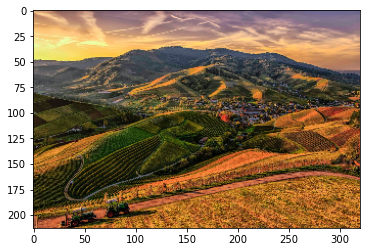

In [2]:
lr = cv2.resize(hr, dsize=(0, 0), fx=0.25, fy=0.25)  # 1/4배
plt.imshow(lr)
print(lr.shape)  # (h, w, c)

3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽습니다.

In [3]:
import numpy as np
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)


def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [4]:
srgan_hr = apply_srgan(lr)

4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 `cv2.resize()`를 사용해 봅시다.

In [5]:
bicubic_hr = cv2.resize(
    lr,
    dsize=(hr.shape[1], hr.shape[0]),
    interpolation=cv2.INTER_CUBIC
)

5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

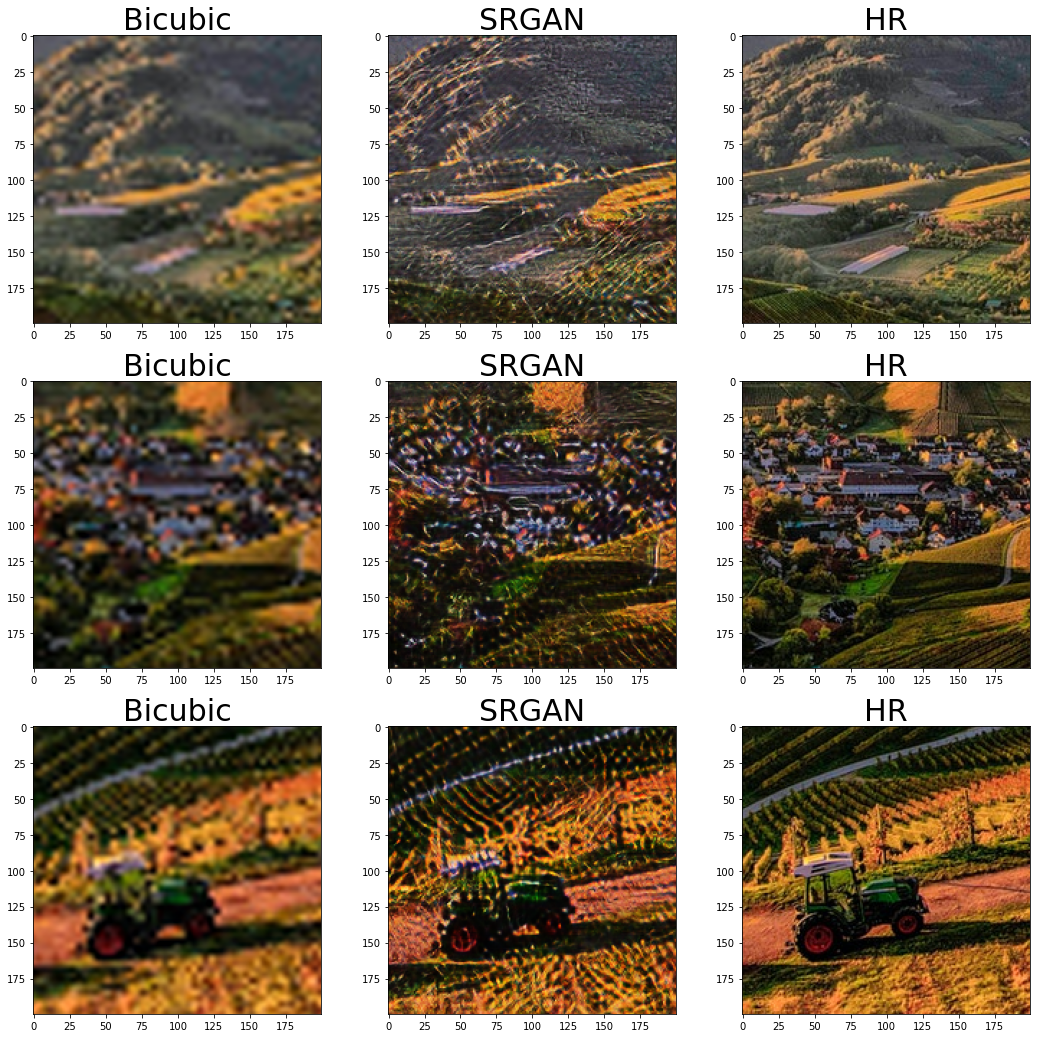

In [6]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(200, 240), (325, 760), (650, 250)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr, left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18, 18))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

Bicubic은 뿌연 이미지가 생성되었고, SRGAN은 뭔가 좀더 디테일한 듯 하지만 여전히 해상도가 낮은 듯한 이미지를 보여줍니다.  
우리가 노드에서 본 것처럼, SRGAN은 제한된 정보를 가지고 이미지를 생성하기 때문에 좀더 디테일한 부분을 창의적으로 구현하지 못한 것으로 보입니다.

### 프로젝트 1-2.

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

(200, 300, 3)


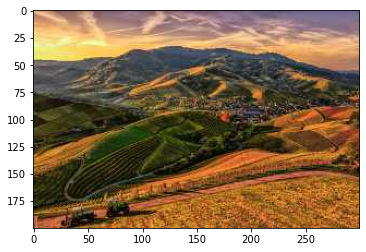

In [7]:
img_lr = cv2.imread('images/pexels-christian-heitz-842711_.jpg', cv2.IMREAD_COLOR)

# RGB로 변환
b, g, r = cv2.split(img_lr)
lr2 = cv2.merge([r, g, b])

plt.imshow(lr2)
print(lr2.shape)  # (h, w, c)

2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽습니다.

(800, 1200, 3)


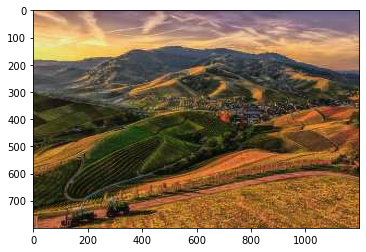

In [8]:
srgan_hr2 = apply_srgan(lr2)
plt.imshow(srgan_hr2)
print(srgan_hr2.shape)

3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. `cv2.resize()`를 사용해 봅시다.

(800, 1200, 3)


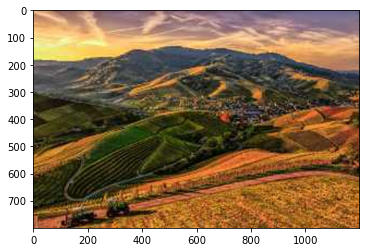

In [9]:
bicubic_hr2 = cv2.resize(
    lr2,
    dsize=(0, 0), fx=4, fy=4,
    interpolation=cv2.INTER_CUBIC
)
plt.imshow(bicubic_hr2)
print(bicubic_hr2.shape)

4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

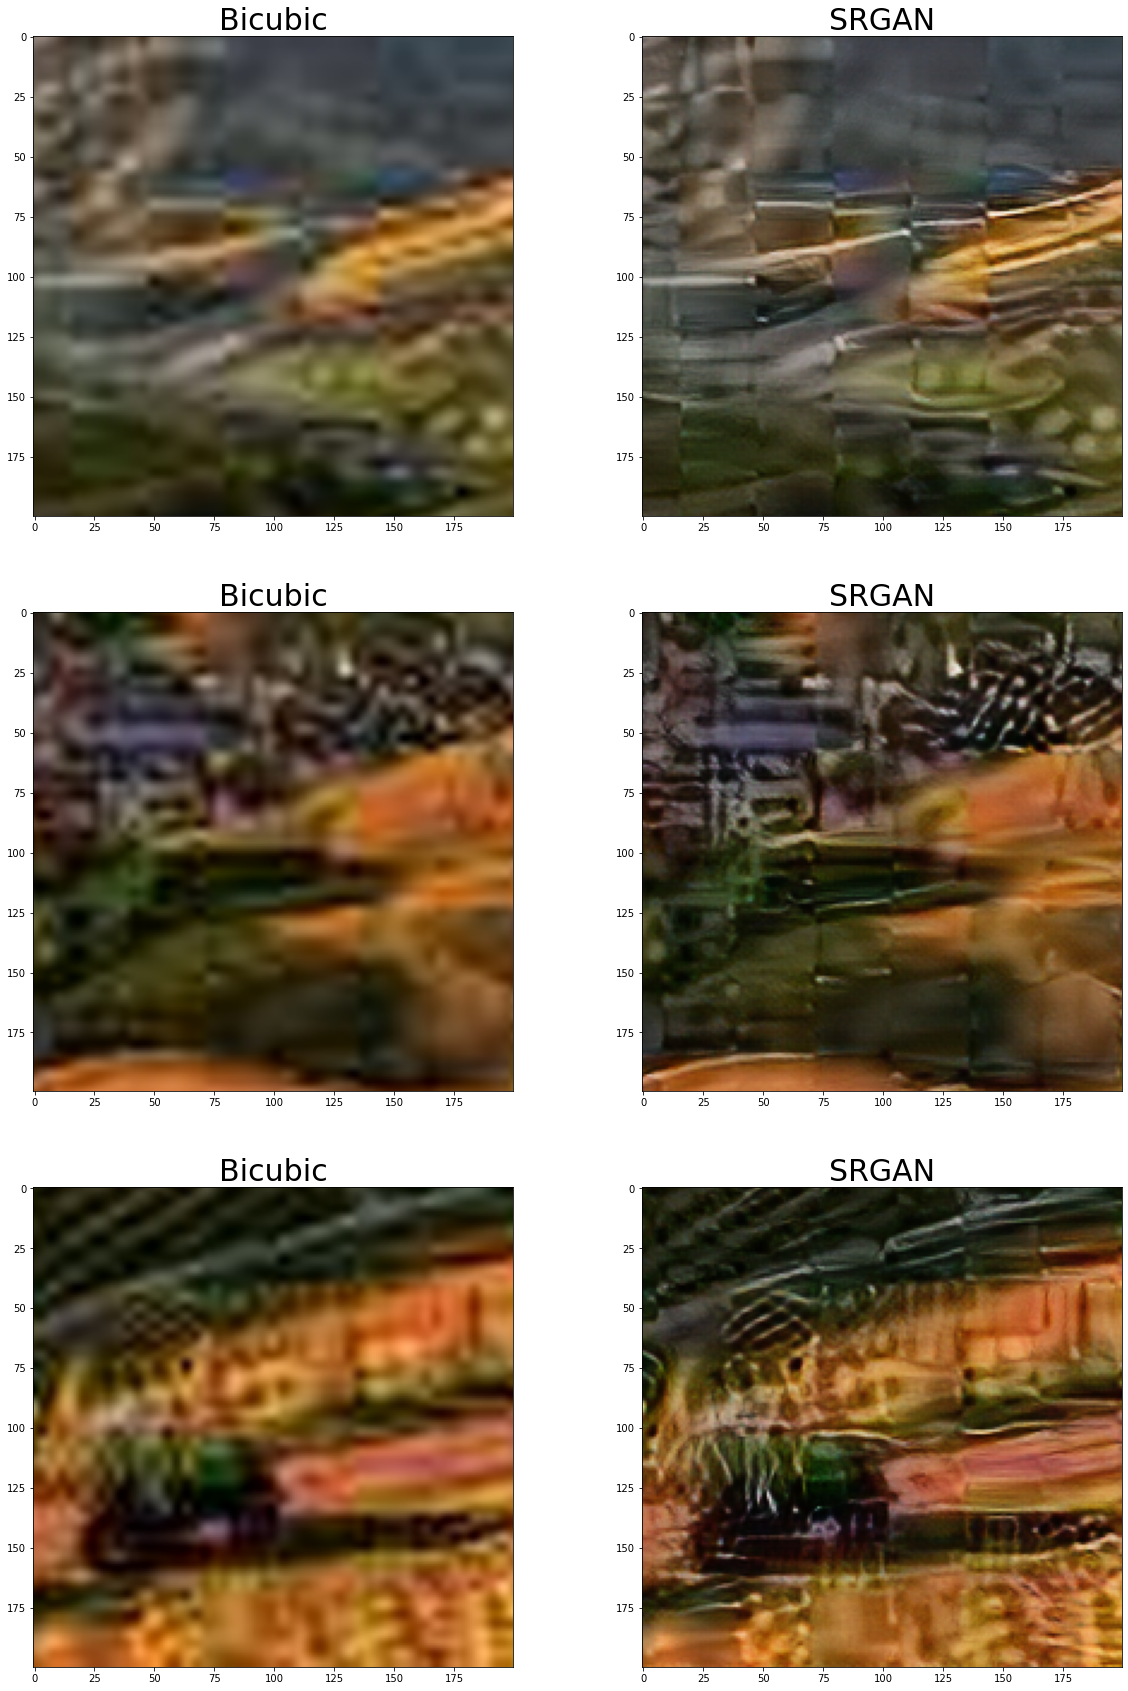

In [10]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(200, 240), (325, 760), (600, 250)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr2, left_top, 200, 200)
    img2 = crop(srgan_hr2, left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(20, 30))
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

워낙 적은 정보를 가지고 큰 이미지를 그려야하기 때문에 두 가지 방법 모두 높은 해상력의 그림을 그리는 데 한계를 보여줍니다.  
SRGAN은 학습 때 배웠던 정보가 있어서 그런지 좀더 디테일하고 샤픈한 이미지를 보여주지만 역시 한계점을 볼 수 있습니다.

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기
---
이전 Super Resolution의 활용 사례에 대해 살펴봤을 때, 단일 이미지가 아닌 영상에 대해 Super Resolution을 적용한 사례가 있었습니다. 이번에는 이미 학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보는 프로젝트를 수행해 봅시다.

실제로 동영상의 Super Resolution은 시간 순서에 따른 다수의 프레임 정보를 고려하는 것이 더 좋지만, 처음부터 학습시키기에 많은 시간이 소요됩니다. 여기서는 이전에 사용했던 SRGAN을 이용해 한 프레임씩 고해상도 이미지로 변환 시켜 모든 프레임에 대해 적용하고, 그 프레임들을 합쳐 동영상으로 만들어 봅시다.

각 프레임들을 모아 gif 파일을 만드는데 아래 라이브러리의 설치가 필요합니다.

```
$ pip install imageio
```

### 1. gif 파일 불러오기
---
아래 주소에 몇 개의 gif 파일이 있습니다. 이 중 하나를 골라 다운 로드하여 아래 과정을 수행합시다. (한 개 이상의 gif 파일에 대해 아래 과정을 수행해야 합니다!)

**GIF files** [https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e](https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e)

다운받은 gif 파일을 아래와 같은 과정을 통해 각 프레임(이미지)을 불러올 수 있습니다. `frames`이란 리스트 안에 각각의 프레임이 들어 있습니다.

```
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("저해상도.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))
```

In [11]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("images/book_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 22
frame 크기 : (215, 380, 3)


### 2. 프레임별 Super Resolution 진행하기
---
Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다. Super Resolution이 완료된 각각의 결과를 `frames_sr`이라는 리스트에 넣어주세요.

In [12]:
frames_sr = []
frames_bc = []
for f in frames:
    frames_sr.append(apply_srgan(f))
    frames_bc.append(cv2.resize(f,
                                dsize=(0, 0), fx=4, fy=4,
                                interpolation=cv2.INTER_CUBIC))

### 3. 프레임을 합쳐 gif 만들기
---
위에서 `frame_sr`을 만들었다면 아래 코드와 같이 gif 파일을 생성할 수 있습니다. Bicubic 및 SRGAN의 결과를 각각 저장하여 2개 파일을 만들어 주세요.

```
import imageio

imageio.mimsave("고해상도.gif", frames_sr)
```

In [13]:
import imageio

imageio.mimsave("images/book_sr.gif", frames_sr)
imageio.mimsave("images/book_bc.gif", frames_bc)

### 4. Jupyter notebook에 gif 표시하기
---
아래와 같이 다운받은 저해상도 gif 파일과 고해상도 gif 파일을 각각 jupyter 내에 출력하여 최종 제출해 주시면 됩니다. jupyter 내에 출력이 어려운 경우, GitHub에 저해상도, 고해상도 gif파일을 업로드 후 링크를 첨부해주시기바랍니다. Super Resolution이 잘 적용되었는지 시각적으로 확인하기 위해 아래의 width 옵션을 적당히 크게 해주세요. 저해상도 및 고해상도 시각화의 width 값은 같도록 설정해주세요.

```
from IPython.display import Image as show_gif

show_gif("저해상도.gif", width=800) # width 는 적당히 큰 값으로 설정해주세요
```

```
show_gif("고해상도.gif", width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요
```

In [21]:
# from IPython.display import Image as show_gif

# show_gif('images/book_lr.gif', width=800)  # width는 적당히 큰 값으로 설정해주세요

In [22]:
# show_gif('images/book_bc.gif', width=800)  # width는 적당히 큰 값으로 설정해주세요

In [23]:
# show_gif('images/book_sr.gif', width=800)  # width는 적당히 큰 값으로 설정해주세요

github에 올리고나니 gif가 보이지 않아 링크로 수정합니다.

- [원본](https://github.com/mochafreddo/aiffel/blob/master/images/book_lr.gif)
- [bicubic interpolation](https://github.com/mochafreddo/aiffel/blob/master/images/book_bc.gif)
- [srgan](https://github.com/mochafreddo/aiffel/blob/master/images/book_sr.gif)

bicubic interpolation은 별 차이가 없어 보이지만, srgan으로 생성한 gif는 선명도가 다른 것을 볼 수 있습니다.

## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|상세기준|
|:---|:---|
|1. SRGAN을 이용해 고해상도의 이미지를 생성하였다.|SRGAN을 통해 생성된 이미지를 제출하였다.|
|2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.|이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.|
|3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.|저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.|

## Postscript

- 급하게 진행하느라 대강 개념만 이해하고 코드를 갖다 썼는데 다행히 돌아갔습니다.
- 그래도 다음에 같은 종류의 프로젝트를 진행할 때 어떻게 해야할 지 알 수 있을 것 같습니다.

## Reference